<a href="https://colab.research.google.com/github/TieuThanh/NLP/blob/master/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# import thư viện

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import os
import math

# Tham khảo

In [ ]:
class Embedder(nn.Module):
    def __init__(self,vocab_size,d_model):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size,d_model)   # Nhận chiều vào là vector biểu diễn trong không gian vector --> chiều dài của model
    
    def forward(self,x):
        return self.embedding(x)


In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self,d_model, max_seq_length=200, dropout=0.1):

        # d_model : chiều dài vector mã hoá cho 1 từ
        # max_seq_length: chiều dài tối đa của 1 câu
        super().__init__()
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_seq_length, d_model)

        # Tính giá trị vị trí 
        # Duyệt theo từng từ 
        # Duyệt theo từng vị trí trong vector embedding của mỗi từ
        # Tính giá trị pos lại đó

        for pos in range(max_seq_length):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/d_model)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/d_model)))
        pe = pe.unsqueeze(0)        
        self.register_buffer('pe', pe)

    def forward(self,x):
        x = x*math.sqrt(self.d_model)
        seq_length = x.size(1)
        pe = Variable(self.pe[:, :seq_length], requires_grad=False)
        if x.is_cuda:
            pe.cuda()
        x = x + pe
        x = self.dropout(x)
        return x


    


In [ ]:
print(PositionalEncoder(512)(torch.rand(2,30, 512)))

tensor([[[16.5730, 17.5884, 22.6510,  ...,  2.6716, 19.3787,  8.8163],
         [ 8.4744,  0.0000,  7.5451,  ...,  3.0019, 24.8393,  8.8058],
         [11.6165,  0.0000,  5.6534,  ..., 12.0409, 16.2691, 25.5825],
         ...,
         [ 3.1663, 22.1153, 23.2498,  ..., 10.0081, 13.0135,  8.4547],
         [ 0.0000,  1.3710,  4.4768,  ..., 13.4082,  6.6823,  4.0773],
         [ 0.1028,  0.0000, 25.7497,  ...,  8.6120, 20.4112, 25.7715]],

        [[18.1363, 22.0186,  9.8603,  ..., 21.0341,  1.2415, 15.4500],
         [ 9.8108,  1.8107, 13.8355,  ..., 10.6060,  9.4583, 22.9378],
         [ 5.3723,  0.0000,  3.0576,  ..., 14.2464, 18.7024,  0.0000],
         ...,
         [ 0.0000,  5.2509, 21.5753,  ...,  9.6383,  0.0000, 19.3181],
         [22.3165,  7.3530, 22.7169,  ...,  1.9941,  7.7166, 21.8150],
         [ 5.5415,  7.2813,  9.7062,  ..., 15.4681, 20.1779, 18.0328]]])


In [ ]:
# Tính attention

def attention(k,q,v, mask = None, dropout = None):

    # kích thước của mỗi vector sẽ là batch_size*số head*chiều dài của câu*embedding của 1 từ 


    d_k = q.size(-1) # Kích thước chiều dài của vector k
    attention_weight = torch.matmul(q,k.transpose(-2, -1))/math.sqrt(d_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        attention_weight = attention_weight.masked_fill(mask==0, -1e9)
    attention_weight = F.softmax(attention_weight, dim=-1)
    if dropout:
        attention_weight = dropout(attention_weight)
    return torch.matmul(attention_weight,v)





In [ ]:
attention(torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512))

tensor([[[[0.5131, 0.5412, 0.4237,  ..., 0.4871, 0.5054, 0.6395],
          [0.5109, 0.5329, 0.4307,  ..., 0.4873, 0.5084, 0.6331],
          [0.5072, 0.5399, 0.4273,  ..., 0.4838, 0.5052, 0.6324],
          ...,
          [0.5119, 0.5434, 0.4235,  ..., 0.4848, 0.5032, 0.6357],
          [0.5166, 0.5340, 0.4248,  ..., 0.4911, 0.5042, 0.6339],
          [0.5180, 0.5271, 0.4310,  ..., 0.4885, 0.5032, 0.6337]],

         [[0.4649, 0.6023, 0.6009,  ..., 0.4631, 0.3767, 0.5179],
          [0.4696, 0.5944, 0.5995,  ..., 0.4637, 0.3822, 0.5237],
          [0.4714, 0.5965, 0.5970,  ..., 0.4657, 0.3875, 0.5178],
          ...,
          [0.4763, 0.5927, 0.5925,  ..., 0.4644, 0.3816, 0.5172],
          [0.4684, 0.5970, 0.5859,  ..., 0.4528, 0.3723, 0.5225],
          [0.4636, 0.6052, 0.5925,  ..., 0.4568, 0.3772, 0.5282]],

         [[0.5457, 0.5010, 0.4981,  ..., 0.4513, 0.5129, 0.4538],
          [0.5499, 0.4932, 0.4945,  ..., 0.4587, 0.5048, 0.4531],
          [0.5539, 0.5002, 0.5027,  ..., 0

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self,num_head,d_model,dropout = 0.01):

        # d_model = d_k * num_head
        super().__init__()
        self.num_head = num_head
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        self.d_k = d_model//num_head

        # 3 ma trận K,Q,V
        self.K = nn.Linear(d_model, d_model)
        self.Q = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)

        # output 
        self.output = nn.Linear(d_model, d_model)

    def forward(self,q,k,v,mask = None):
        
        # q = batch_size * chiều dài của câu*chiều dài vector embbed

        bs = q.size(0) # batch size
        q = self.Q(q).view(bs, -1, self.num_head, self.d_k)
        k = self.K(k).view(bs, -1, self.num_head, self.d_k)
        v = self.V(v).view(bs, -1, self.num_head, self.d_k)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        # tính attention
        scores = attention(q, k, v, mask, self.dropout)
        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)
        output = self.output(concat)
        return output



In [ ]:
MultiHeadAttention(8, 512)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 30, 512)).shape

torch.Size([32, 30, 512])

In [ ]:
class Norm(nn.Module):
    def __init__(delf,d_model,eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [ ]:
class FeedForward(nn.Module):
    """ Trong kiến trúc của chúng ta có tầng linear 
    """
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
    
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        """
        x: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        
        
        x2 = self.norm_1(x)
        # tính attention value, các bạn để ý q, k, v là giống nhau        
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

# EncoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32 , 1, 30)).shape

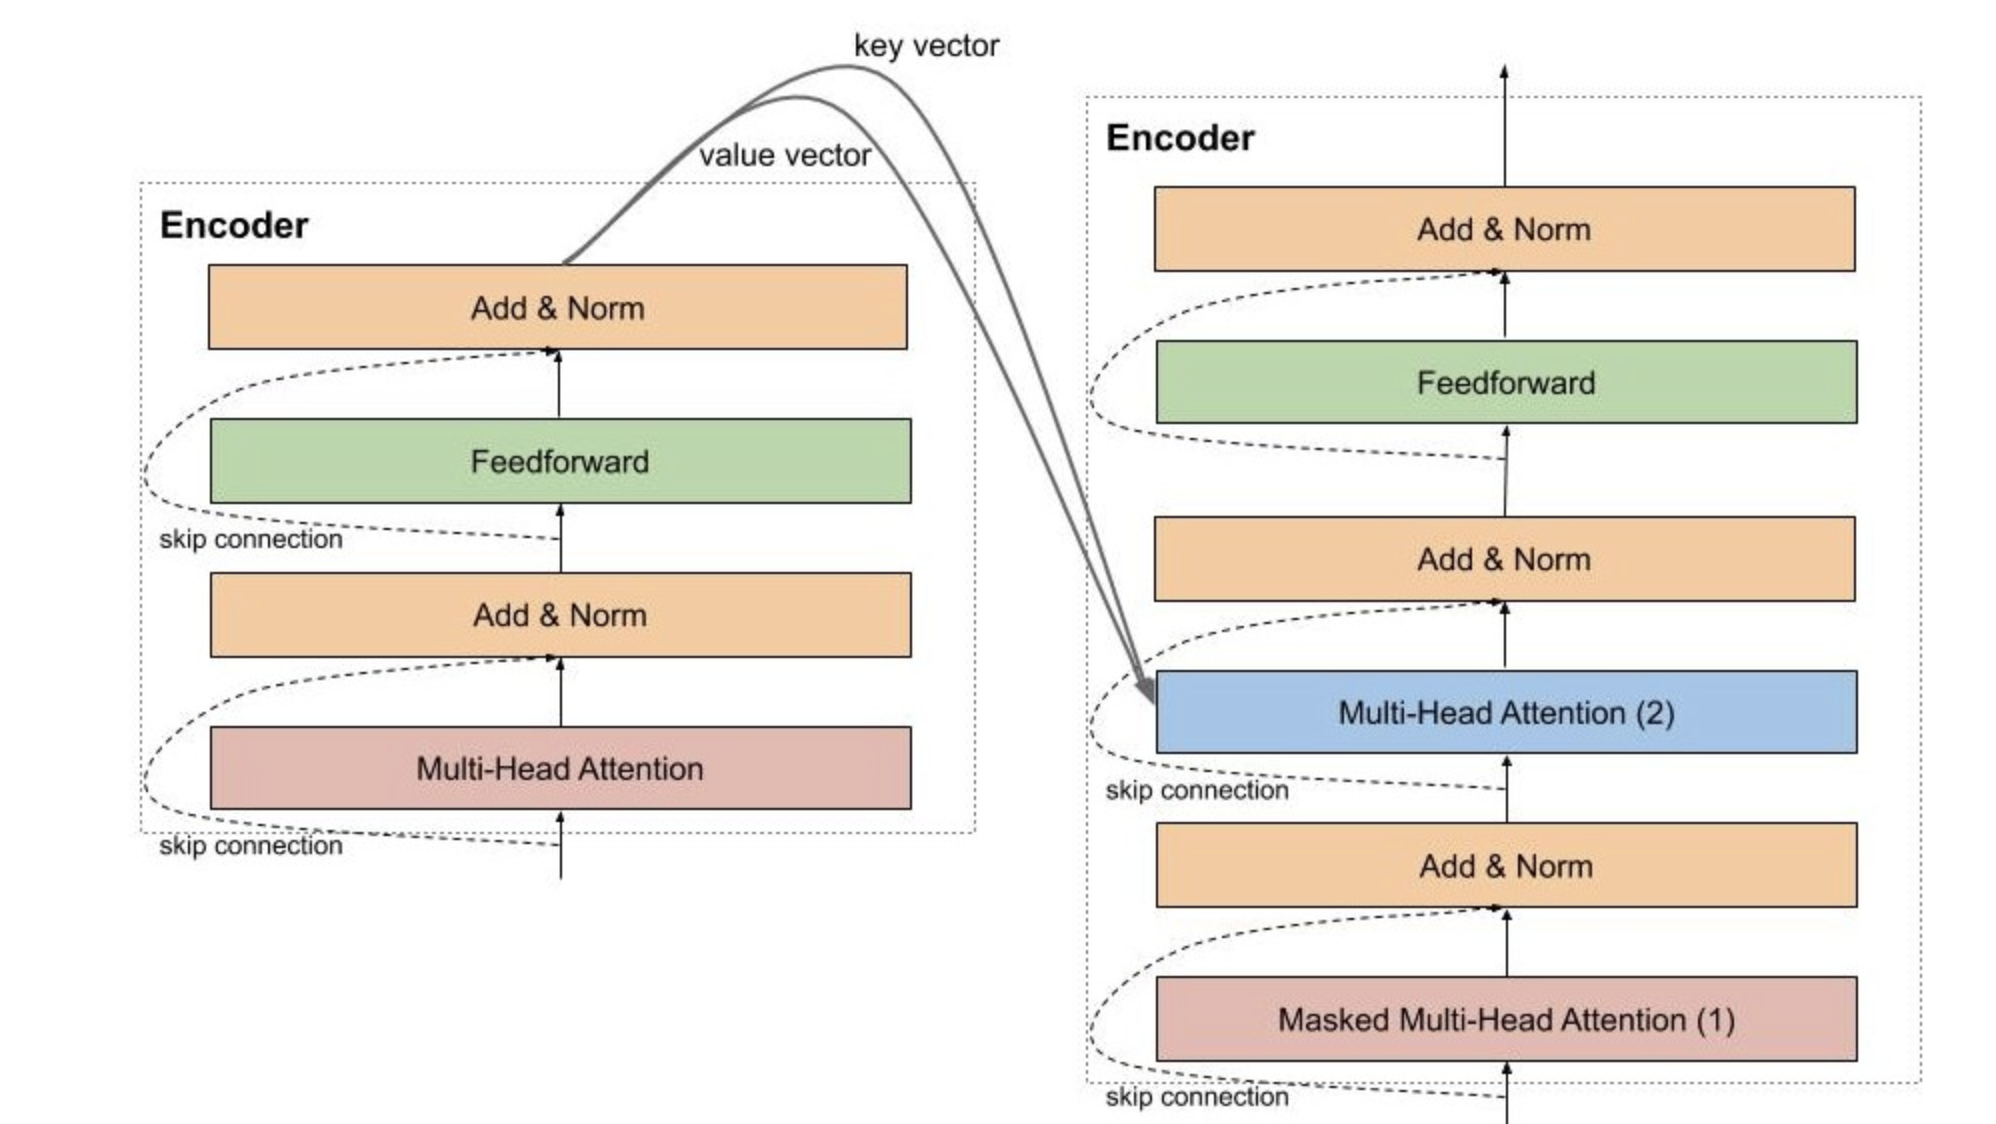

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        """
        x: batch_size x seq_length x d_model
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x 1 x seq_length
        """
        # Các bạn xem hình trên, kiến trúc mình vẽ với code ở chỗ này tương đương nhau.
        x2 = self.norm_1(x)
        # multihead attention thứ nhất, chú ý các từ ở target 
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        # masked mulithead attention thứ 2. k, v là giá trị output của mô hình encoder
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

In [ ]:
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    """Một encoder có nhiều encoder layer nhé !!!
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
        
    def forward(self, src, mask):
        """
        src: batch_size x seq_length
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

# Encoder(232, 512,6,8,0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 1, 30)).shape

In [ ]:
    """Một decoder có nhiều decoder layer nhé !!!
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        """
        trg: batch_size x seq_length
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)
    
# Decoder(232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape

In [ ]:
class Transformer(nn.Module):
    """ Cuối cùng ghép chúng lại với nhau để được mô hình transformer hoàn chỉnh
    """
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        """
        src: batch_size x seq_length
        trg: batch_size x seq_length
        src_mask: batch_size x 1 x seq_length
        trg_mask batch_size x 1 x seq_length
        output: batch_size x seq_length x vocab_size
        """
        e_outputs = self.encoder(src, src_mask)
        
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output
    
# Transformer(232, 232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.LongTensor(32, 30).random_(0, 10),torch.rand(32, 1, 30),torch.rand(32, 1, 30)).shape

# Emplement


In [ ]:
class Embedding(nn.Module):
    def __init__(self,vocab_size,d_model):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size,d_model)   # Nhận chiều vào là vector biểu diễn trong không gian vector --> chiều dài của model
    def forward(self,x):
        return self.embedding(x)

In [ ]:
class Position(nn.Module):
    def __init__(self,d_emb,max_length = 512):
        super().__init__()
        # Khởi tạo ma trận 0 kích thước (max_length,d_emb)
        pe = torch.zeros(max_length, d_emb)
        
        for i in range(max_length):
            for j in range(0,d_emb,2):
                w_k = 1/(10000**((2*j)/d_emb))
                pe[i,j] = math.sin(w_k*i)
                pe[i,j+1] = math.cos(w_k*i)
        pe = pe.unsqueeze(0)
        self.weight = nn.Parameter(pe, requires_grad=False)
        
    def forward(self,x):
        # return x + pos(x)
        return self.weight[:,:x.size(1),:] + x


In [ ]:
Position(512)(torch.rand(2, 30, 512))

In [ ]:
class ScaleDotProduct(nn.Module):
    def __init__(self,drop = .01):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.softmax = nn.Softmax()
    
    def forward(self,K,Q,V, mask = None):
        d_k = K.size(-1)
        attn = torch.matmul(K,Q.transpose(-2,-1))/math.sqrt(d_k)
        attn = self.softmax(attn)
        if mask != None: 
            attn = attn.masked_fill(mask, 0)
        attn = self.drop(attn)
        return torch.matmul(attn,V)




In [ ]:
AttentionHead(512,64)(torch.rand(3,32,512),torch.rand(3,32,512),torch.rand(3,32,512)).shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


torch.Size([3, 32, 64])

In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, d_model, d_feature, drop = 0.1):
        """
        d_model: Kích thước của embedding 
        d_feature: chiều dài của matrix k,q,v
        """
        super().__init__()
        self.K = nn.Linear(d_model, d_feature)
        self.Q = nn.Linear(d_model,d_feature)
        self.V = nn.Linear(d_model,d_feature)
        self.attn = ScaleDotProduct()
    def forward(self,queries,keys, values, mask = None):
        Q = self.Q(queries)
        K = self.K(keys)
        V = self.V(values)
        attn = self.attn(K,Q,V)
        return attn

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self,num_heads,d_model, d_feature, drop=.1):
        super().__init__()
        self.num_heads = num_heads
        # Tạo một list gồm n_head attn head
        self.attn_heads = nn.ModuleList([
                                         AttentionHead(d_model,d_feature,drop) for _ in range(num_heads)
        ])

        self.W_0 = nn.Linear(d_feature*num_heads, d_model)
    def forward(self,queries, keys, values, mask=None):

        # Tính attention cho tất cả các heads
        x = [attn(queries, keys, values, mask=None) for _, attn in enumerate(self.attn_heads)]

        # concat
        x = torch.cat(x,dim = -1)
        return self.W_0(x)


In [ ]:
MultiHeadAttention(512//6,512,50)(torch.rand(3,32,512),torch.rand(3,32,512),torch.rand(3,32,512))

In [ ]:
class Encoder(nn.Module):
    def __init__(self,d_model = 512, d_feature = 64, d_ff = 2048, num_heads = 8, drop = .1):
        super().__init__()
        assert d_model == d_feature * num_heads, "exepected d_model == num_heads*d_feature"

        self.attn_heads = MultiHeadAttention(num_heads=num_heads,d_model=d_model,d_feature=d_feature,drop = drop)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(drop)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model,d_ff),
            nn.LeakyReLU(.01),
            nn.Linear(d_ff,d_model)
        )
    def forward(self,x, mask = None):
        attn = self.attn_heads(x,x,x,mask = mask)
        norm = self.layer_norm1(attn)
        x = x + self.drop(norm)
        ff = self.feed_forward(x)
        norm = self.layer_norm2(ff)
        x = x + self.drop(norm)
        return x




In [ ]:
class MultiBlockEncoder(nn.Module):
    def __init__(self,d_model = 512,d_feature = 64 ,num_layers = 8 ,drop=.1):
        super().__init__()
        self.Encode_layers = nn.ModuleList([Encoder(d_model,d_feature,drop=drop) for _ in range(num_layers)])
        self.pos = Position(d_model)
    def forward(self,x: torch.FloatTensor, mask = None):
        x = self.pos(x) 
        for encoder in self.Encode_layers:
            x = encoder(x)
        return x

In [ ]:
x = torch.rand(3,32,512)
MultiBlockEncoder(512,64,8)(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self,d_model = 512, d_feature = 64, d_ff = 2048 , num_heads = 8, drop = .1):
        super().__init__()
        self.mask_attn_heads = MultiHeadAttention(num_heads= num_heads,d_model=d_model,d_feature=d_feature,drop = drop)
        self.attn_heads = MultiHeadAttention(num_heads= num_heads,d_model=d_model,d_feature=d_feature,drop = drop)
        self.drop = nn.Dropout(drop)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.layer_norm3 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model,d_ff),
            nn.LeakyReLU(.1),
            nn.Linear(d_ff,d_model)
        )
    def forward(self,x,src_mask = None,tgt_mask = None):
        mask_attn_heads = self.mask_attn_heads(x,x,x,src_mask)
        norm = self.layer_norm1(mask_attn_heads)
        x = x + self.drop(norm)

        # key và value đc lấy từ kết quả của encoder
        attn = self.attn_heads(mask_attn_heads,x,x,mask=tgt_mask)
        norm  = self.layer_norm2(attn)
        x = x + self.drop(norm)
        ff = self.feed_forward(x)
        norm = self.layer_norm3(ff)
        return x + self.drop(norm)




In [ ]:
x = torch.rand(3,32,512)
Decoder(512,64,8)(x)

In [ ]:
class MultiBlockDecoder(nn.Module):
    def __init__(self,d_model = 512 ,d_feature = 64, num_layers = 8, drop = .1):
        super().__init__()
        self.Decode_layers = nn.ModuleList([Decoder(d_model,d_feature,drop=drop) for _ in range(num_layers)])
        self.pos = Position(d_model)
    
    def forward(self,x,src_mask = None,tgt_mask = None):
        x = self.pos(x)
        for decoder in self.Decode_layers:
            x = decoder(x,src_mask,tgt_mask)
        return x


In [ ]:
x = torch.rand(3,32,512)
MultiBlockDecoder(512,64,8)(x)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, voc_size, d_model = 512, d_feature = 64, num_layers = 8, drop = .1):
        super().__init__()
        self.Encoders = MultiBlockEncoder(d_model,d_feature,num_layers,drop)
        self.Decoders = MultiBlockDecoder(d_model,d_feature,num_layers,drop)
        self.Embed = Embedding(voc_size, d_model)
        self.fc = nn.Linear(d_model, voc_size)
    
    def forward(self,x,mask1 = None, mask2 = None):
        x = self.Embed(x)
        x = self.Encoders(x, mask1)
        x = self.Decoders(x,mask1, mask2)
        return self.fc(x)
    

In [ ]:
x = torch.LongTensor(32, 30).random_(0, 10)
Transformer(768)(x)

# Translate

In [20]:
!pip install transformers
!pip install vncorenlp
!wget https://github.com/vncorenlp/VnCoreNLP/blob/master/VnCoreNLP-1.1.1.jar

--2020-11-05 16:19:07--  https://github.com/vncorenlp/VnCoreNLP/blob/master/VnCoreNLP-1.1.1.jar
Resolving github.com (github.com)... 13.229.188.59
Connecting to github.com (github.com)|13.229.188.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘VnCoreNLP-1.1.1.jar.1’

VnCoreNLP-1.1.1.jar     [ <=>                ]  78.17K  --.-KB/s    in 0.006s  

2020-11-05 16:19:08 (13.7 MB/s) - ‘VnCoreNLP-1.1.1.jar.1’ saved [80042]



## Download data

In [123]:
os.makedirs('./data/', exist_ok=True)
!gdown --id 1Fuo_ALIFKlUvOPbK5rUA5OfAS2wKn_95

Downloading...
From: https://drive.google.com/uc?id=1Fuo_ALIFKlUvOPbK5rUA5OfAS2wKn_95
To: /content/drive/My Drive/NLP in DL/transformer/en_vi.zip
10.1MB [00:00, 61.6MB/s]


In [124]:
!unzip -o en_vi.zip

Archive:  en_vi.zip
  inflating: data/tst2013.en         
  inflating: data/tst2012.vi         
  inflating: data/train.en           
  inflating: data/tst2013.vi         
  inflating: data/train.vi           
  inflating: data/tst2012.en         


## Xử lý dữ liệu

In [141]:
opt = {
    'train_src_data':'./data/train.en',
    'train_tgt_data':'./data/train.vi',
    'valid_src_data':'./data/tst2013.en',
    'valid_tgt_data':'./data/tst2013.vi',
    'src_lang':'en',
    'tgt_lang':'en',#'vi_spacy_model',
    'max_strlen':160,
    'batchsize':1500,
    'device':'cuda',
    'd_model': 512,
    'n_layers': 6,
    'heads': 8,
    'dropout': 0.1,
    'lr':0.0001,
    'epochs':30,
    'printevery': 200,
    'k':5,
}

In [157]:
from torchtext import data
from nltk.corpus import wordnet
import spacy
import re
import os
import dill as pickle
import pandas as pd
from transformers import AutoTokenizer
from vncorenlp import VnCoreNLP
from torchtext.data import TabularDataset, Iterator, BucketIterator


In [148]:
import spacy
import re

class tokenize(object):
    def __init__(self, lang):
        self.nlp = spacy.load(lang)
    def tokenizer(self, sentence):
        sentence = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
        sentence = re.sub(r"[ ]+", " ", sentence)
        sentence = re.sub(r"\!+", "!", sentence)
        sentence = re.sub(r"\,+", ",", sentence)
        sentence = re.sub(r"\?+", "?", sentence)
        sentence = sentence.lower()
        return [tok.text for tok in self.nlp.tokenizer(sentence) if tok.text != " "]

In [ ]:
# Mặt nạ cho phần Decode
def De_mask(d_model,device):
    # Tạo một ma trận bậc thang vuông
    np_mask = np.triu(np.ones((1,d_model,d_model)),k = 1).astype('unit8')
    np_mask = Variable(torch.from_numpy(np_mask) == 0)
    np_mask = np_mask.to(device)
    return np_mask

# Mặt nạ cho Encoder --> bỏ qua những vị trí padding
def En_mask(src, tgt, src_pad, tgt_pad, device):
    src_mask = (src != src_pad).unsqueeze(-2)

    if tgt != None:
        rg_mask = (trg != trg_pad).unsqueeze(-2)
        size = trg.size(1)
        np_mask = De_mask(size, device)
        if trg.is_cuda:
            np_mask.cuda()
        trg_mask = trg_mask & np_mask
    else:
        trg_mask = None
    return src_mask, trg_mask


In [120]:
# Load Dictionary từ wordnet
from nltk.corpus import wordnet
def get_synonym(word, SRC):
    syns = wordnet.synsets(word)
    for s in syns:
        for l in s.lemmas():
            if SRC.vocab.stoi[l.name()] != 0:
                return SRC.vocab.stoi[l.name()]

In [121]:
def create_fields(src_lang, tgt_lang):
    
    # Lấy kiểu tokenize của mỗi tập data
    t_src = tokenize(src_lang)
    t_tgt = tokenize(tgt_lang)

    # Tạo trường tương ứng
    TGT = data.Field(lower=True, tokenize=t_tgt.tokenizer, init_token='<sos>', eos_token='<eos>')
    SRC = data.Field(lower=True, tokenize=t_src.tokenizer)
        
    return SRC, TGT

In [128]:
def read_data(src,tgt):
    src_data = open(src).read().strip().split('\n')
    tgt_data = open(tgt).read().strip().split('\n')
    return src_data, tgt_data

In [131]:
X_train,Y_train = read_data(opt['train_src_data'],opt['train_tgt_data'])
X_test, Y_test = read_data(opt['valid_src_data'],opt['valid_tgt_data'])

In [143]:
SRC, TGT = create_fields(opt['src_lang'], opt['tgt_lang'])
train_iter = create_dataset(X_train, Y_train, opt['max_strlen'], opt['batchsize'], opt['device'], SRC, TRG, istrain=True)
valid_iter = create_dataset(X_test, Y_test ,id_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'], SRC, TRG, istrain=False)

loading spacy tokenizers...


In [147]:
SRC.vocab_cls

torchtext.vocab.Vocab